In [1]:
import os
import math
import pandas as pd

import matplotlib.pyplot as plt

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:
notebook_path = os.path.abspath("explore_data.ipynb")
notebook_dir = os.path.dirname(notebook_path)

project_root = os.path.dirname(os.path.dirname(notebook_dir))
os.chdir(project_root)

In [3]:
store_loc_df = pd.read_excel("./data/Logistic Details_JH_Last 15 Days.xlsx", sheet_name="Store Lat Long")
wh_loc_df = pd.read_excel("./data/Logistic Details_JH_Last 15 Days.xlsx", sheet_name="WH Lat Long")
vehicles_df = pd.read_excel("./data/Logistic Details_JH_Last 15 Days.xlsx", sheet_name="Vehicles")
demand_df = pd.read_excel("./data/Logistic Details_JH_Last 15 Days.xlsx", sheet_name="Last 15 Days Demand")
demand_df = demand_df.drop_duplicates().reset_index(drop=True)
min_vehical_capacity = vehicles_df["Weight Capacity in KG"].min()
demand_df["Weight (in kg)"] = demand_df["Weight (in kg)"].apply(lambda x: x % min_vehical_capacity)

In [4]:
# ============== Haversine Distance ==============
def haversine_km(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """Compute Haversine distance in km between two (lat, lon) points."""
    R = 6371  # Earth radius in km
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlam = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlam/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def parse_lat_long(s):
    """Parse 'lat,lon' string to (lat, lon) tuple."""
    parts = str(s).strip().split(",")
    return float(parts[0]), float(parts[1])

In [ ]:
# ============== Shared Data Setup ==============
MAX_STORES = None  # Set to e.g. 20 for faster testing with fewer stores

# Build store name -> (lat, lon) mapping
store_coords = {}
for _, row in store_loc_df.iterrows():
    store_coords[row["store_name"]] = parse_lat_long(row["Lat Long"])

# Warehouse coords
wh_row = wh_loc_df.iloc[0]
wh_name = wh_row["WH Name"]
wh_coords = parse_lat_long(wh_row["Lat Long"])

# Get all unique dates from demand data
all_dates = sorted(demand_df["delivery_date"].dt.date.unique())
# all_dates = [all_dates[9]]
print(f"Dates in demand data: {len(all_dates)}")
print(f"Date range: {all_dates[0]} to {all_dates[-1]}")

Dates in demand data: 1
Date range: 2026-01-10 to 2026-01-10


In [14]:
# ============== Build Distance/Time Matrix & Time Windows ==============
# Nodes: 0 = depot (warehouse), 1..n = stores, n+1..n+M = depot return nodes (reload)
AVG_SPEED_KMH = 30  # Average speed for travel time
SERVICE_TIME_MIN = 15  # Minutes to unload at each store
RELOAD_DISCOURAGE_TIME = 10000  # Large time to avoid spurious depot->reload->depot trips

def time_to_minutes(t):
    """Convert datetime time to minutes since midnight."""
    if hasattr(t, "hour"):
        return t.hour * 60 + t.minute
    return 0

def min_to_time_str(m):
    """Convert minutes since midnight to HH:MM string."""
    return f"{m // 60:02d}:{m % 60:02d}"

def build_matrices_for_stores(stores_with_demand, max_vehicle_capacity, max_trips_per_vehicle=1):
    """Build time matrix, time windows, demands, and store->time_window mapping for given stores.
    If max_trips_per_vehicle > 1, adds depot return nodes for multi-trip reload."""
    locations = [wh_coords]
    store_names = ["DEPOT"]
    store_cities = ["DEPOT"]
    store_tw_map = {}  # store_name -> (start_min, end_min, start_time_str, end_time_str)
    for _, row in stores_with_demand.iterrows():
        locations.append(store_coords[row["store_name"]])
        store_names.append(row["store_name"])
        store_cities.append(row["city"])
        sm = time_to_minutes(row["start_time"])
        em = time_to_minutes(row["end_time"])
        store_tw_map[row["store_name"]] = (sm, em, min_to_time_str(sm), min_to_time_str(em))
    n = len(locations)
    depot_return_indices = []
    if max_trips_per_vehicle > 1 and max_vehicle_capacity > 0:
        num_reloads = max_trips_per_vehicle - 1
        for i in range(num_reloads):
            locations.append(wh_coords)
            store_names.append(f"DEPOT_RETURN_{i+1}")
            store_cities.append("DEPOT")
            depot_return_indices.append(n + i)
        n = len(locations)
    dist_km = [[0.0] * n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_km[i][j] = haversine_km(locations[i][0], locations[i][1], locations[j][0], locations[j][1])
    time_matrix = []
    for i in range(n):
        row = []
        for j in range(n):
            if i == j:
                row.append(0)
            elif i == 0 and j in depot_return_indices:
                row.append(RELOAD_DISCOURAGE_TIME)
            elif j == 0 and i in depot_return_indices:
                row.append(RELOAD_DISCOURAGE_TIME)
            elif i in depot_return_indices and j in depot_return_indices:
                row.append(RELOAD_DISCOURAGE_TIME)
            else:
                travel_min = int((dist_km[i][j] / AVG_SPEED_KMH) * 60)
                service = SERVICE_TIME_MIN if (j > 0 and j not in depot_return_indices) else 0
                row.append(travel_min + service)
        time_matrix.append(row)
    time_windows = [(0, 24 * 60)]
    for _, row in stores_with_demand.iterrows():
        time_windows.append((time_to_minutes(row["start_time"]), time_to_minutes(row["end_time"])))
    for _ in depot_return_indices:
        time_windows.append((0, 24 * 60))
    demands = [0] + stores_with_demand["Weight (in kg)"].astype(int).tolist()
    for _ in depot_return_indices:
        demands.append(-max_vehicle_capacity)
    return time_matrix, time_windows, demands, store_names, store_cities, store_tw_map, locations, depot_return_indices

In [15]:
# ============== Vehicle Setup (Fixed + Adhoc) ==============
ADHOC_PER_CITY = 5  # Pool of Adhoc vehicles per city (on-demand)
ADHOC_FIXED_COST = 50000  # Penalty so optimizer prefers Fixed vehicles
SOFT_TW_LOWER_PENALTY = 10   # Small penalty per min for early arrival (vehicle waits until start)
SOFT_TW_UPPER_PENALTY = 10000  # Large penalty per min for late arrival (missing time window)
MAX_TRIPS_PER_VEHICLE = 3  # Same vehicle can do multiple trips within 12h working hours
VEHICLE_WORKING_MINUTES = 12 * 60  # 12 hours max per vehicle

fixed_vehicles = vehicles_df[vehicles_df["Type"] == "Fixed"].dropna(subset=["Vehicle Count"])
adhoc_vehicles = vehicles_df[vehicles_df["Type"] == "Adhoc"]

vehicle_capacities = []
vehicle_types = []  # "Fixed" or ("Adhoc", city)
vehicle_names = []  # Human-readable name for each vehicle

fixed_n = 0
for _, row in fixed_vehicles.iterrows():
    count = int(row["Vehicle Count"])
    cap_kg = int(row["Weight Capacity in KG"])
    loc = row.get("Location", row.get("Vehicle Name", "WH"))
    loc = loc if pd.notna(loc) else "WH"
    vehicle_capacities.extend([cap_kg] * count)
    vehicle_types.extend(["Fixed"] * count)
    for _ in range(count):
        fixed_n += 1
        vehicle_names.append(f"Fixed-{loc}-{fixed_n}")
adhoc_n = 0
for _, row in adhoc_vehicles.iterrows():
    cap_kg = int(row["Weight Capacity in KG"])
    city = row["Location"]
    for _ in range(ADHOC_PER_CITY):
        adhoc_n += 1
        vehicle_capacities.append(cap_kg)
        vehicle_types.append(("Adhoc", city))
        vehicle_names.append(f"Adhoc-{city}-{adhoc_n}")

num_fixed = sum(1 for t in vehicle_types if t == "Fixed")
num_adhoc = len(vehicle_types) - num_fixed
print(f"Fixed vehicles: {num_fixed}, Adhoc vehicles: {num_adhoc}")

Fixed vehicles: 18, Adhoc vehicles: 15


In [ ]:
# ============== Build and Solve VRP with OR-Tools ==============
def solve_vrp(time_matrix, time_windows, demands, vehicle_capacities, vehicle_types,
              store_cities, depot=0, adhoc_fixed_cost=50000, soft_tw_lower=10, soft_tw_upper=10000,
              depot_return_indices=None, vehicle_working_minutes=12*60):
    """Solve CVRP with soft time windows. Vehicles may arrive early (wait until start) or late.
    If depot_return_indices is provided, vehicles can return to depot to reload (multi-trip)."""
    depot_return_indices = depot_return_indices or []
    max_cap = max(vehicle_capacities)
    num_vehicles = len(vehicle_capacities)
    manager = pywrapcp.RoutingIndexManager(len(time_matrix), num_vehicles, depot)
    routing = pywrapcp.RoutingModel(manager)

    # Time callback (transit time between nodes)
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return time_matrix[from_node][to_node]

    transit_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    # Adhoc vehicles: high fixed cost so optimizer prefers Fixed vehicles
    for v in range(num_vehicles):
        if vehicle_types[v] != "Fixed":
            routing.SetFixedCostOfVehicle(adhoc_fixed_cost, v)

    # Time dimension (12h max per vehicle)
    routing.AddDimension(
        transit_cb_idx, 60, vehicle_working_minutes, False, "Time"
    )
    time_dim = routing.GetDimensionOrDie("Time")
    # Soft time windows: early arrival allowed (vehicle waits); small penalty for early, large for late
    for i, tw in enumerate(time_windows):
        idx = manager.NodeToIndex(i)
        if i != depot:
            time_dim.SetCumulVarSoftLowerBound(idx, tw[0], soft_tw_lower)
            time_dim.SetCumulVarSoftUpperBound(idx, tw[1], soft_tw_upper)

    # Capacity dimension: slack_max allows depot returns to reset load (reload pattern)
    def demand_callback(from_index):
        return demands[manager.IndexToNode(from_index)]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_cb_idx, max_cap, vehicle_capacities, True, "Capacity"
    )
    capacity_dim = routing.GetDimensionOrDie("Capacity")
    # Store nodes: slack = 0. Depot return nodes: keep default slack (0..max_cap) for reload
    for i in range(len(demands)):
        if i != depot and i not in depot_return_indices:
            capacity_dim.SlackVar(manager.NodeToIndex(i)).SetValue(0)
    # Depot returns: optional (disjunction with 0 cost) - use only when reload needed
    for node in depot_return_indices:
        routing.AddDisjunction([manager.NodeToIndex(node)], 0)

    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.seconds = 30

    solution = routing.SolveWithParameters(search_params)
    return solution, routing, manager, time_dim

In [25]:
# ============== Solve VRP for All Dates & Build Combined Output ==============
all_rows = []
solution = None  # Keep last solution for downstream cells (Adhoc comparison, plot)
routing = manager = time_dim = routes_data = None

for date in all_dates:
    day_demand = demand_df[demand_df["delivery_date"].dt.date == date].copy()
    if day_demand.empty:
        print(f"  {date}: No demand data")
        continue
    store_demand = day_demand.groupby("store_name").agg({
        "Weight (in kg)": "sum",
        "start_time": "first",
        "end_time": "first",
        "city": "first"
    }).reset_index()
    stores_with_demand = store_demand[store_demand["store_name"].isin(store_coords)].copy()
    if MAX_STORES:
        stores_with_demand = stores_with_demand.head(MAX_STORES)
    if stores_with_demand.empty:
        continue
    time_matrix, time_windows, demands, store_names, store_cities, store_tw_map, locations, depot_return_indices = build_matrices_for_stores(
        stores_with_demand, max_vehicle_capacity=max(vehicle_capacities), max_trips_per_vehicle=MAX_TRIPS_PER_VEHICLE
    )
    sol, routing, manager, time_dim = solve_vrp(
        time_matrix, time_windows, demands, vehicle_capacities, vehicle_types,
        store_cities, adhoc_fixed_cost=ADHOC_FIXED_COST,
        soft_tw_lower=SOFT_TW_LOWER_PENALTY, soft_tw_upper=SOFT_TW_UPPER_PENALTY,
        depot_return_indices=depot_return_indices, vehicle_working_minutes=VEHICLE_WORKING_MINUTES
    )
    if not sol:
        print(f"  {date}: No solution found")
        continue
    solution = sol
    routes_data = []
    for v in range(len(vehicle_capacities)):
        if not routing.IsVehicleUsed(solution, v):
            continue
        index = routing.Start(v)
        route_stops = []
        route_load = 0
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route_load += demands[node]
            time_var = time_dim.CumulVar(index)
            arr_min = solution.Min(time_var)
            name = store_names[node]
            route_stops.append({"node": node, "store": name, "load_kg": route_load, "arrival": arr_min})
            index = solution.Value(routing.NextVar(index))
        route_stops.append({"node": manager.IndexToNode(index), "store": "DEPOT", "load_kg": route_load, "arrival": solution.Min(time_dim.CumulVar(index))})
        routes_data.append(route_stops)
    for v, route in enumerate(routes_data):
        vname = vehicle_names[v] if v < len(vehicle_names) else f"Vehicle-{v}"
        vtype = "Adhoc" if vehicle_types[v] != "Fixed" else "Fixed"
        cap = vehicle_capacities[v]
        used_cap = sum(demands[s["node"]] for s in route if s["store"] != "DEPOT" and not s["store"].startswith("DEPOT_RETURN"))
        for stop in route:
            if stop["store"] != "DEPOT" and not stop["store"].startswith("DEPOT_RETURN"):
                tw = store_tw_map.get(stop["store"], (0, 0, "?", "?"))
                all_rows.append({
                    "date": date,
                    "vehicle": v,
                    "vehicle_name": vname,
                    "vehicle_type": vtype,
                    "capacity_kg": cap,
                    "used_capacity_kg": used_cap,
                    "store": stop["store"],
                    "arrival_min": stop["arrival"],
                    "arrival_time": min_to_time_str(stop["arrival"]),
                    "tw_start_min": tw[0],
                    "tw_end_min": tw[1],
                    "tw_start_time": tw[2],
                    "tw_end_time": tw[3],
                    "load_kg": stop["load_kg"]
                })
    print(f"  {date}: Solution found ({len(routes_data)} vehicles used)")

routes_summary_all = pd.DataFrame(all_rows)
print(f"\nTotal stops across all dates: {len(routes_summary_all)}")
TARGET_DATE = all_dates[-1] if all_dates else None  # For downstream cells (Adhoc comparison, plot)

  2026-01-10: Solution found (32 vehicles used)

Total stops across all dates: 73


In [26]:
# ============== Routes Summary (All Dates) ==============
# Combined output: date, vehicle info, store, arrival_time, time window (tw_start_time, tw_end_time)
if not routes_summary_all.empty:
    try:
        display(routes_summary_all)
    except NameError:
        print(routes_summary_all.to_string())
else:
    print("No solutions found for any date.")

,date,vehicle,vehicle_name,vehicle_type,capacity_kg,used_capacity_kg,store,arrival_min,arrival_time,tw_start_min,tw_end_min,tw_start_time,tw_end_time,load_kg
0,2026-01-10,0,Fixed-All Over JH-1,Fixed,2000,1897,AM Argora KM Road RNC,658,10:58,600,720,10:00,12:00,672
1,2026-01-10,0,Fixed-All Over JH-1,Fixed,2000,1897,AM Khunti Road Tupudana Chowk RNC,694,11:34,720,840,12:00,14:00,1897
2,2026-01-10,1,Fixed-All Over JH-2,Fixed,2000,1940,AM Zakir Hussain Rd HZB,518,08:38,420,540,07:00,09:00,874
3,2026-01-10,1,Fixed-All Over JH-2,Fixed,2000,1940,AM New Nutan Nagar HZB,540,09:00,540,660,09:00,11:00,1940
4,2026-01-10,2,Fixed-All Over JH-3,Fixed,2000,1967,AM RIMS Jora Talab RNC,463,07:43,420,540,07:00,09:00,592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2026-01-10,29,Adhoc-Jamshedpur-12,Adhoc,1800,1717,AM JP Market Dhurwa RNC,480,08:00,360,480,06:00,08:00,1717
69,2026-01-10,30,Adhoc-Jamshedpur-13,Adhoc,1800,1597,AM Old Argora RNC,675,11:15,660,780,11:00,13:00,914
70,2026-01-10,30,Adhoc-Jamshedpur-13,Adhoc,1800,1597,ASM Imli Chowk Harmu,693,11:33,720,840,12:00,14:00,1597
71,2026-01-10,31,Adhoc-Jamshedpur-14,Adhoc,1800,1602,AM New Chunabhatta RNC,400,06:40,360,480,06:00,08:00,284


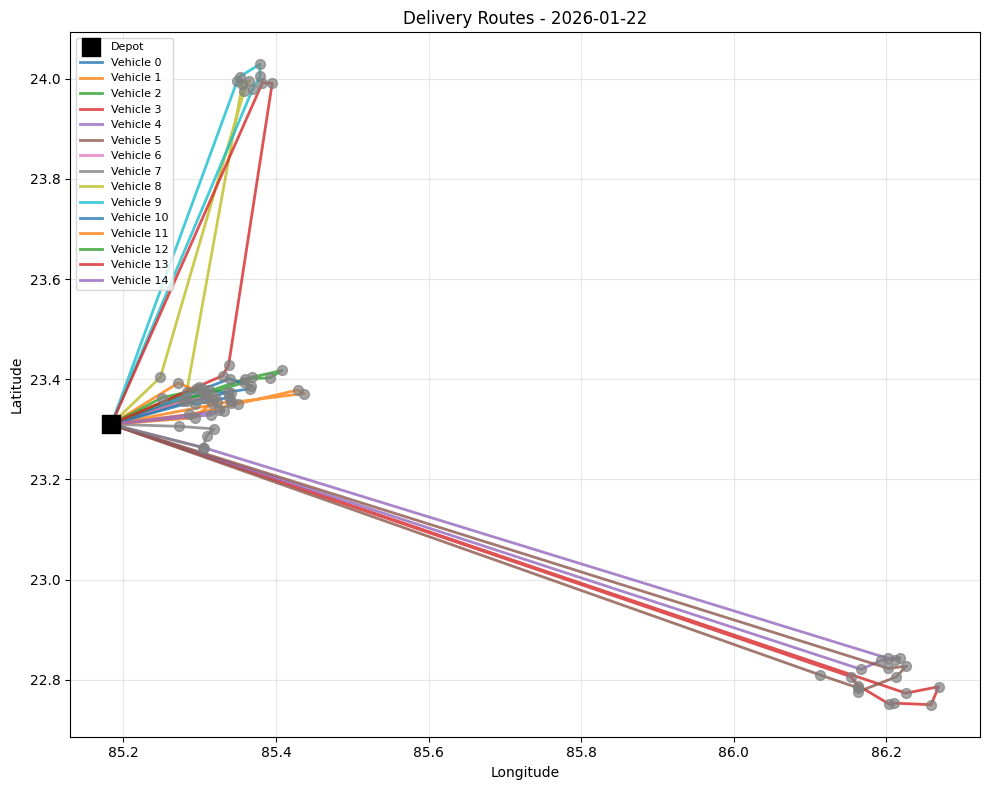

In [12]:
# ============== Optional: Plot Routes ==============
if solution and "routes_data" in dir():
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = plt.cm.tab10.colors
    # Plot depot
    ax.scatter(wh_coords[1], wh_coords[0], c="black", s=150, marker="s", label="Depot", zorder=5)
    # Plot stores
    for i, (lat, lon) in enumerate(locations[1:], 1):
        ax.scatter(lon, lat, c="gray", s=50, alpha=0.7, zorder=3)
    # Plot routes
    for v, route in enumerate(routes_data):
        lats, lons = [], []
        for stop in route:
            node = stop["node"]
            lats.append(locations[node][0])
            lons.append(locations[node][1])
        ax.plot(lons, lats, "-", color=colors[v % len(colors)], linewidth=2, label=f"Vehicle {v}", alpha=0.8)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Delivery Routes - {TARGET_DATE}")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()